In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import pyro

/home/aqoku/miniconda3/envs/cellij/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import muvi
import cellij
from cellij.core.synthetic import DataGenerator

In [4]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7f78fb6fcb40>


In [5]:
# plotting functions
def _lines(ax, positions, ymin, ymax, horizontal=False, **kwargs):
    if horizontal:
        ax.hlines(positions, ymin, ymax, **kwargs)
    else:
        ax.vlines(positions, ymin, ymax, **kwargs)
    return ax


def lined_heatmap(data, figsize=None, hlines=None, vlines=None, **kwargs):
    """Plot heatmap with horizontal or vertical lines."""
    if figsize is None:
        figsize = (20, 2)
    fig, g = plt.subplots(figsize=figsize)
    g = sns.heatmap(data, ax=g, **kwargs)
    if hlines is not None:
        _lines(
            g,
            hlines,
            *sorted(g.get_xlim()),
            horizontal=True,
            lw=1.0,
            linestyles="dashed",
        )
    if vlines is not None:
        _lines(
            g,
            vlines,
            *sorted(g.get_ylim()),
            horizontal=False,
            lw=1.0,
            linestyles="dashed",
        )
    return g

In [6]:
# random seed to use throughout the notebook
seed = 123

# basic parameters
n_samples = 200
n_features = [400, 400, 400, 400]
n_views = len(n_features)
likelihoods = ["Normal" for _ in range(n_views)]

# more specific parameters to the structure of the latent factors
n_fully_shared_factors = 20
n_partially_shared_factors = 0
n_private_factors = 0

# optional: number of covariates to generate
n_covariates = 0

In [7]:
dg = DataGenerator(
    n_samples,
    n_features,
    likelihoods,
    n_fully_shared_factors,
    n_partially_shared_factors,
    n_private_factors,
    n_covariates=n_covariates,
)

rng = dg.generate(seed=seed)

# center data
dg.normalize(with_std=False)

2023-05-05 15:03:50,041 - cellij.core.synthetic - WARNING - Using a uniform distribution with parameters 0.05 and 0.15 for generating the number of active factor loadings.


In [8]:
feature_offsets = [0] + np.cumsum(n_features).tolist()
vlines = feature_offsets[1:-1]

<Axes: >

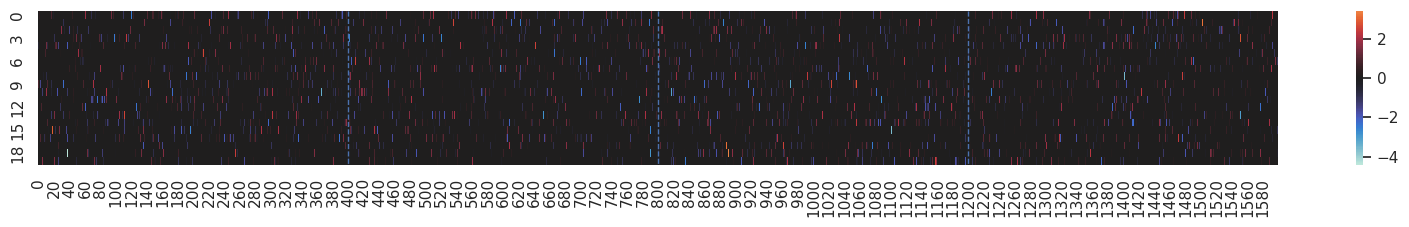

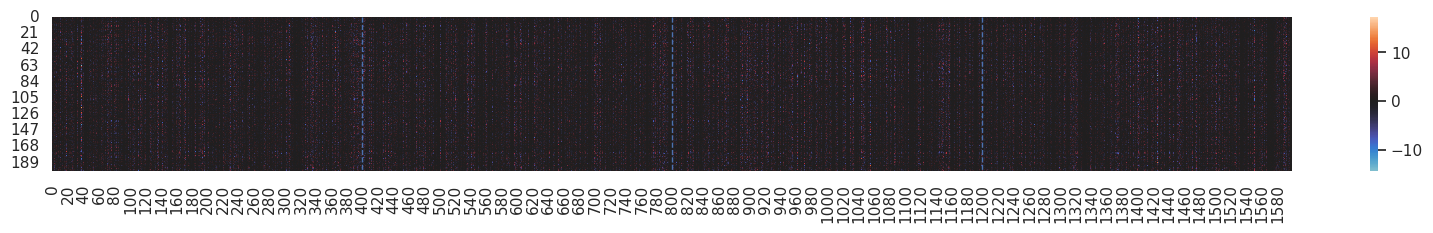

In [9]:
# factor loadings should be fairly sparse
lined_heatmap(dg.w, vlines=vlines, center=0)
lined_heatmap(dg.y, vlines=vlines, center=0)

In [10]:
mdata = dg.to_mdata()
mdata

MuData object with n_obs × n_vars = 200 × 1600
  obsm:	'z'
  4 modalities
    feature_group_0:	200 x 400
      varm:	'w', 'w_mask'
    feature_group_1:	200 x 400
      varm:	'w', 'w_mask'
    feature_group_2:	200 x 400
      varm:	'w', 'w_mask'
    feature_group_3:	200 x 400
      varm:	'w', 'w_mask'

In [11]:
# create an instance of the model
model = muvi.tl.from_mdata(mdata, n_factors=dg.n_factors, reg_hs=False)

2023-05-05 15:03:53,313 - muvi.core.models - WARNING - No view names provided!
2023-05-05 15:03:53,314 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2023-05-05 15:03:53,315 - muvi.core.models - INFO - pd.DataFrame detected.
2023-05-05 15:03:53,316 - muvi.core.models - INFO - Storing the index of the view `feature_group_0` as sample names.
2023-05-05 15:03:53,317 - muvi.core.models - INFO - pd.DataFrame detected.
2023-05-05 15:03:53,317 - muvi.core.models - INFO - pd.DataFrame detected.
2023-05-05 15:03:53,318 - muvi.core.models - INFO - pd.DataFrame detected.
2023-05-05 15:03:53,319 - muvi.core.models - INFO - pd.DataFrame detected.
2023-05-05 15:03:53,320 - muvi.core.models - INFO - pd.DataFrame detected.
2023-05-05 15:03:53,323 - muvi.core.models - INFO - pd.DataFrame detected.
2023-05-05 15:03:53,324 - muvi.core.models - INFO - pd.DataFrame detected.
2023-05-05 15:03:53,324 - muvi.core.models - INFO - Likelihoods set to `{'f

In [12]:
n_epochs = 10000
model.fit(
    batch_size=n_samples,
    n_epochs=n_epochs,
    n_particles=20,
    learning_rate=0.01,
    optimizer="clipped",
    verbose=1,
    seed=seed,
    callbacks=[
        # log_callback,
        muvi.EarlyStoppingCallback(
            n_epochs, window_size=10, tolerance=1e-5, patience=10
        ),
    ],
)

2023-05-05 15:03:56,641 - muvi.core.models - INFO - Using 20 particles in parallel.
2023-05-05 15:03:56,642 - muvi.core.models - INFO - Preparing model and guide...
2023-05-05 15:03:56,643 - muvi.core.models - WARNING - No prior feature sets provided, running model uninformed.
2023-05-05 15:03:57,852 - muvi.core.models - INFO - Preparing optimizer...
2023-05-05 15:03:57,853 - muvi.core.models - INFO - Decaying learning rate over 10000 iterations.
2023-05-05 15:03:57,854 - muvi.core.models - INFO - Preparing SVI...
2023-05-05 15:03:57,855 - muvi.core.models - INFO - Preparing training data...
2023-05-05 15:03:57,884 - muvi.core.models - INFO - Using complete dataset.
2023-05-05 15:03:57,886 - muvi.core.models - INFO - Setting training seed to `123`.
2023-05-05 15:03:57,888 - muvi.core.models - INFO - Cleaning parameter store.
2023-05-05 15:03:57,890 - muvi.core.models - INFO - Starting training...


  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-05 15:03:58,498 - root - INFO - Guessed max_plate_nesting = 3


 39%|███▊      | 3860/10000 [01:45<02:48, 36.47it/s, ELBO=826]   

Relative improvement of -9.33e-05 < 1e-05 for 10 step(s) in a row, stopping early.
2023-05-05 15:05:43,734 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


In [13]:
z_hat = model.get_factor_scores()
w_hat = np.concatenate([model.get_factor_loadings()[vn] for vn in model.view_names], axis=1)

x_hat = np.matmul(z_hat, w_hat)

print(z_hat.shape, w_hat.shape, x_hat.shape)


(200, 20) (20, 1600) (200, 1600)


<Axes: >

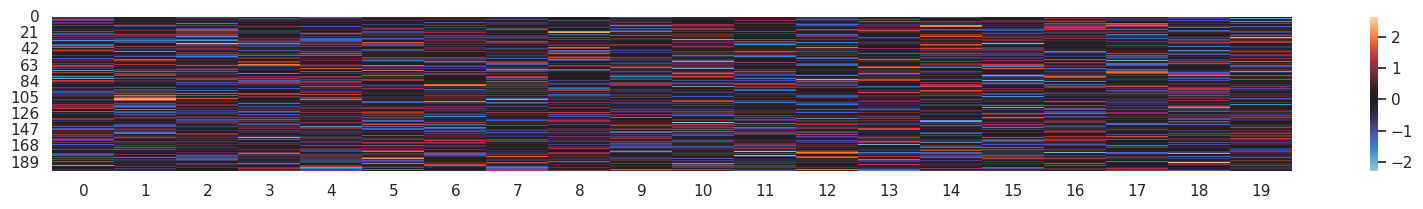

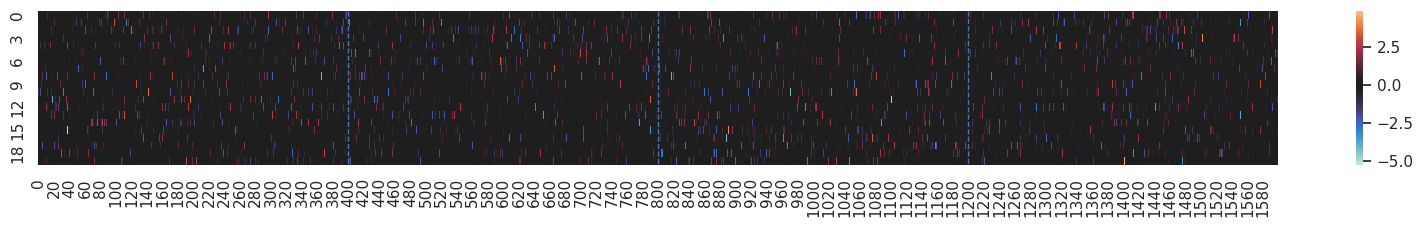

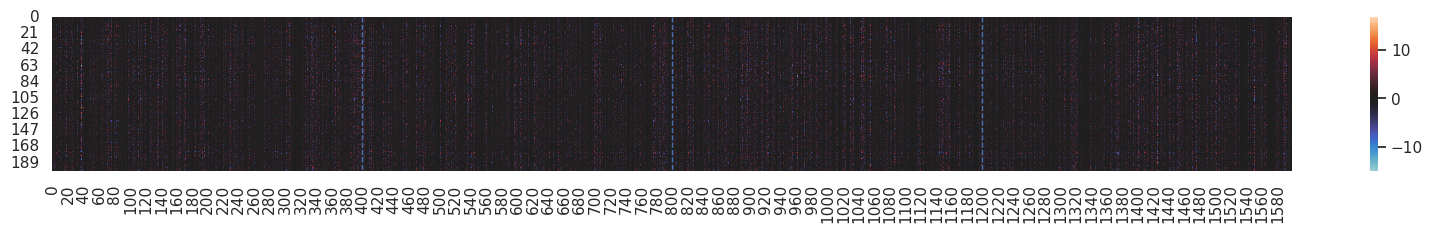

In [14]:

lined_heatmap(z_hat, vlines=vlines, center=0)
lined_heatmap(w_hat, vlines=vlines, center=0)
lined_heatmap(x_hat, vlines=vlines, center=0)
# lined_heatmap(sigma_hat[np.newaxis, :], vlines=vlines, center=0)

In [15]:
from scipy.optimize import linear_sum_assignment
from scipy.stats import pearsonr

from sklearn.metrics import pairwise_distances, mean_squared_error, r2_score
from sklearn.metrics import precision_recall_fscore_support, PrecisionRecallDisplay
from sklearn.metrics.pairwise import cosine_similarity

In [16]:
r2_score(dg.y, x_hat)

0.756705133311381

In [17]:
def get_opt_thresh(X, Y, thresh_min=0, thresh_max=1, n_thresh=101):
    thresh_max = min(thresh_max, Y.max())
    print(thresh_max)
    thresholds = np.linspace(thresh_min, thresh_max, n_thresh)
    f1s = []
    for threshold in thresholds:
        prec, rec, f1, _ = precision_recall_fscore_support(
            X.flatten(), (Y > threshold).flatten(), average="binary"
        )
        f1s.append(f1)

    return thresholds[np.argmax(f1s)]

In [18]:
opt_order = linear_sum_assignment(-np.abs(pairwise_distances(
    dg.w,
        w_hat,
        metric=lambda a, b: pearsonr(a, b)[0],
        force_all_finite=False,
    )))[-1]
opt_order

array([ 2,  3, 18,  1, 12,  7,  5,  6, 19, 10,  8, 14,  9, 13,  0, 11,  4,
       16, 15, 17])

In [19]:
w_hat = w_hat[opt_order, :]
z_hat = z_hat[:, opt_order]

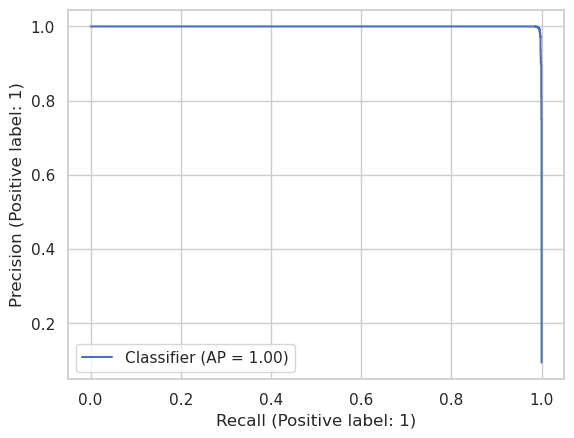

In [20]:
PrecisionRecallDisplay.from_predictions(dg.w_mask.flatten(), np.abs(w_hat).flatten())

In [21]:
threshold = get_opt_thresh(
    dg.w_mask,
    w_hat,
    0,
    2,
)
threshold

2


0.1

<Axes: >

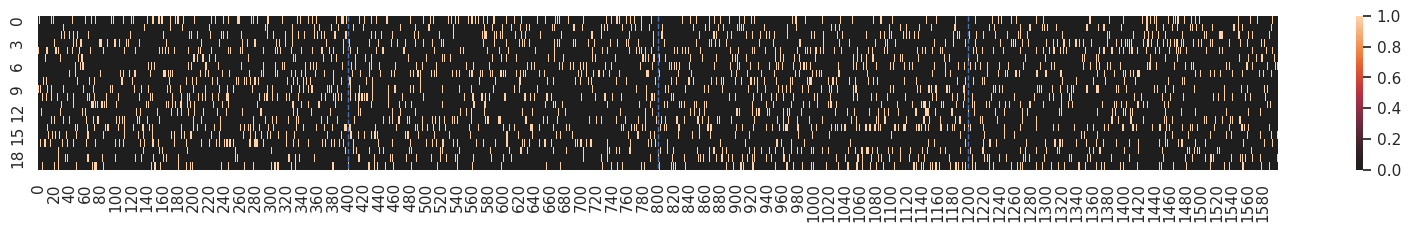

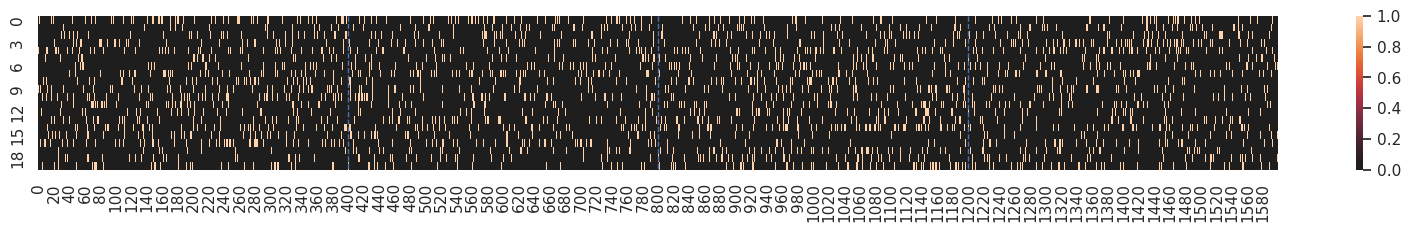

In [22]:
lined_heatmap(dg.w_mask, vlines=vlines, center=0)
lined_heatmap(np.abs(w_hat) > threshold, vlines=vlines, center=0)

In [23]:
precision_recall_fscore_support((dg.w_mask).flatten(), (np.abs(w_hat) > threshold).flatten(), average="binary")

(0.9907742998352553, 0.9956953642384105, 0.9932287365813377, None)